In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib widget

/var/folders/wj/bw8g86p56yq5f9gwsp5vq4640000gq/T/ipykernel_86117/410919452.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def plot_map_histogram(df,variable,bins1,bins2,vmin,vmax,label=''):
    
    plt.figure(figsize=(10,4))

    ax1 = plt.subplot(121)
    plt.scatter(df['X']/1000.,df['Y']/1000.,c=df[variable],cmap='magma',s=1,vmin=vmin,vmax=vmax)
    plt.axis('equal')
    plt.colorbar(orientation='vertical',label=label)
    plt.xlabel('PS Easting (km)')
    plt.ylabel('PS Northing (km)')
    
    ax2 = plt.subplot(122)
    plt.hist(df[variable],bins=bins1,color='k');
    # Grounded and Not a Lake
    plt.hist(df[(df['Grounded']==True) & (df['Lake']==False)][variable],bins=bins1,color='grey');
    # Floating
    plt.hist(df[df['Grounded']==False][variable],bins=bins1,color='lightgrey');
    # Lakes
    plt.hist(df[df['Lake']==True][variable],bins=bins2,color='skyblue');

    plt.xlim(vmin,vmax)
    plt.ylabel('# Traces')
    plt.xlabel(label)
    plt.tight_layout()
    
    return

In [3]:
### Load the processed reflectivity dataframe ###

df = pd.read_csv('../../proc/Processed_Reflectivity.csv')

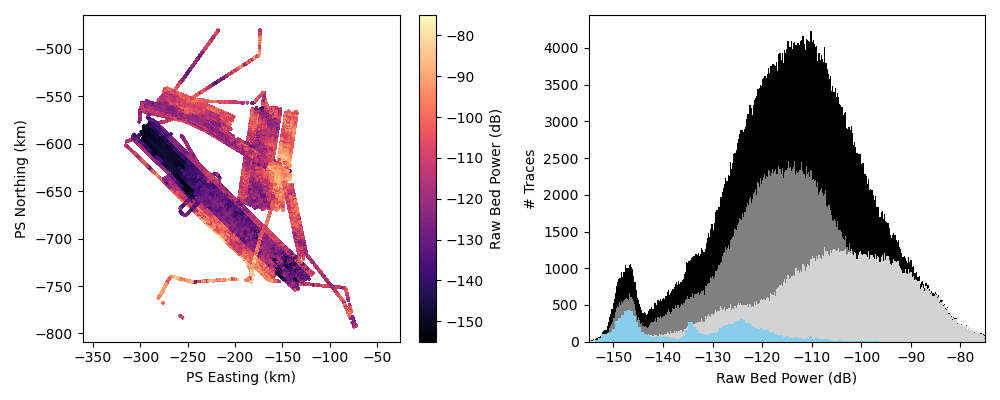

In [4]:
# Raw Picked Power
plot_map_histogram(df,'P_bed',500,100,-155,-75,label='Raw Bed Power (dB)')
plt.savefig('fig-S1-1.png',dpi=300)

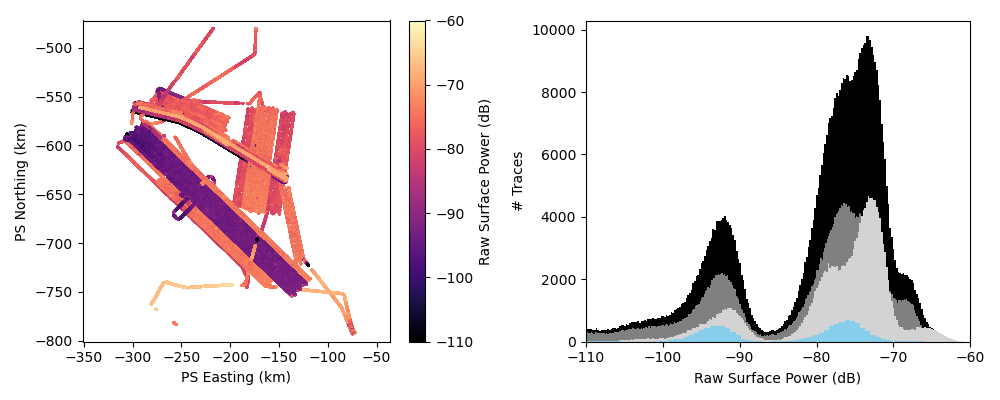

In [16]:
# Raw Picked Power of surface reflection
plot_map_histogram(df,'P_surf',500,100,-110,-60,label='Raw Surface Power (dB)')
plt.savefig('fig-S1-2.png',dpi=300)

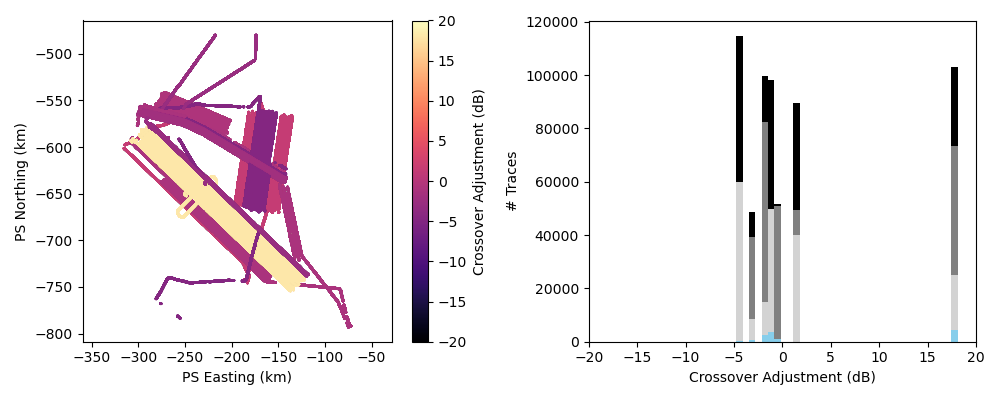

In [19]:
# Crossover Adjustments
df['M'] = df['P_bed_adj'] - df['P_bed']
plot_map_histogram(df,'M',35,35,-20,20,'Crossover Adjustment (dB)')
plt.savefig('fig-S1-3.png',dpi=300)

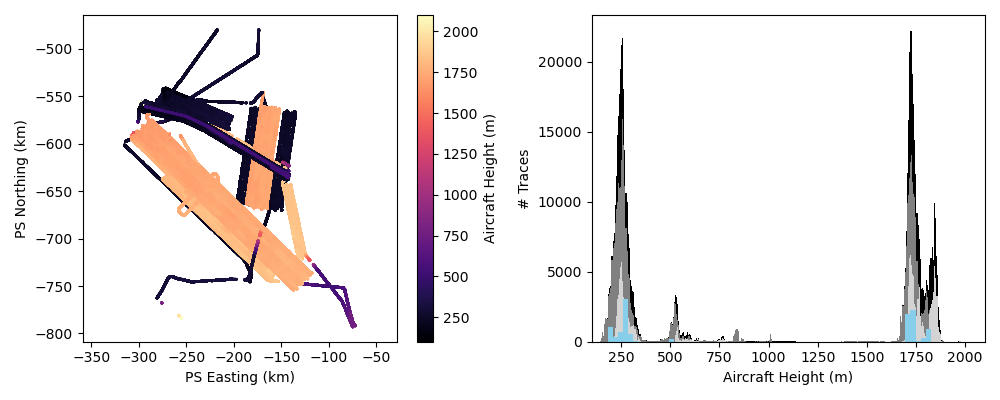

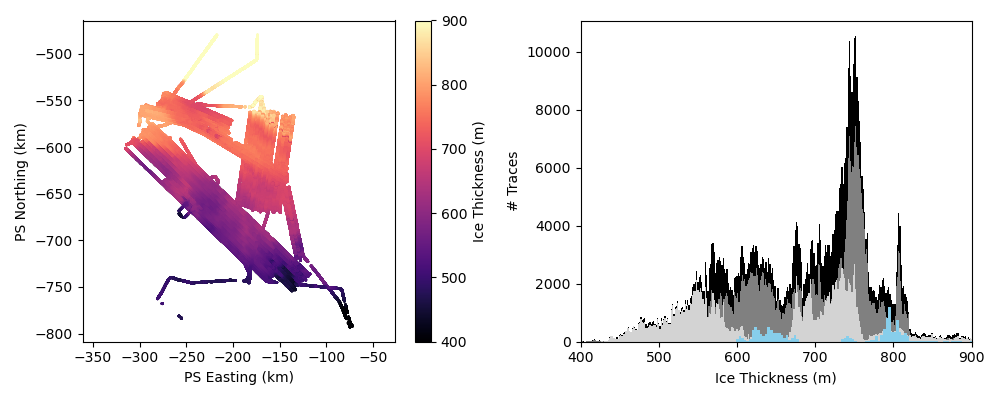

In [7]:
# Aircraft height above ice
plot_map_histogram(df,'h',500,100,100,2100,'Aircraft Height (m)')
plt.savefig('fig-S1-4.png',dpi=300)
# Ice Thickness
plot_map_histogram(df,'H',500,100,400,900,'Ice Thickness (m)')
plt.savefig('fig-S1-5.png',dpi=300)

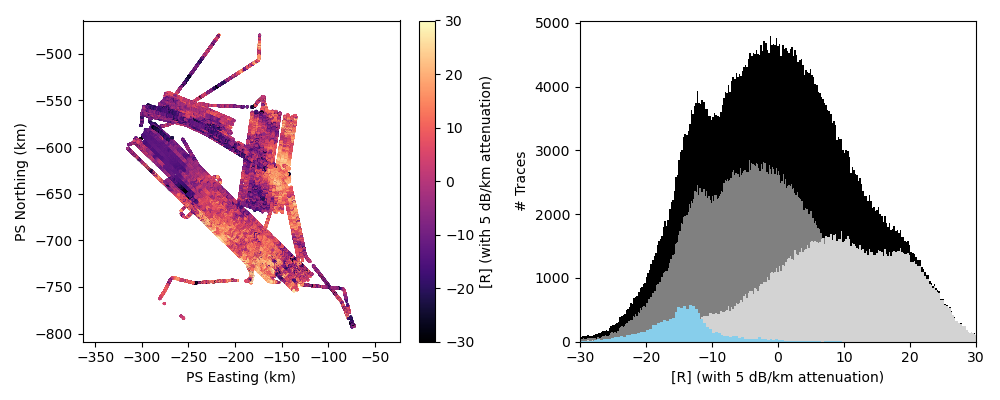

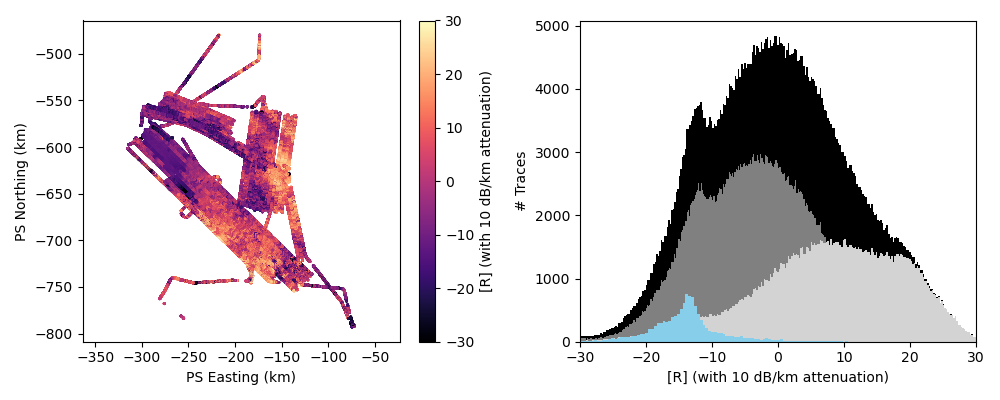

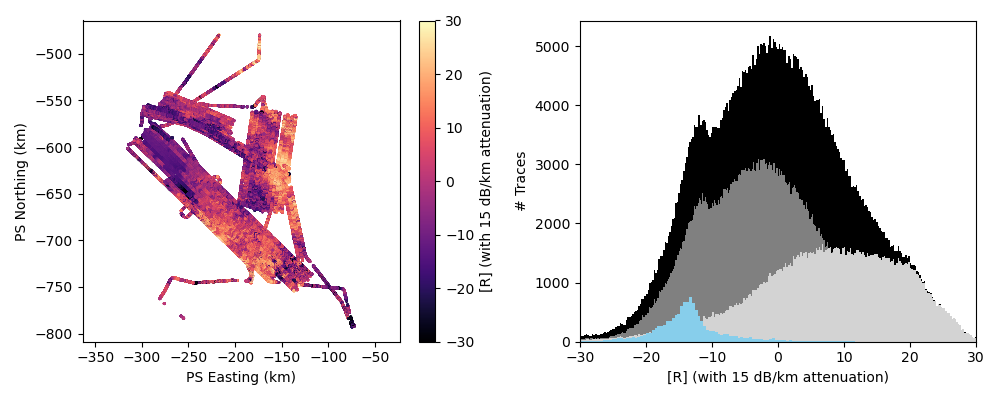

In [9]:
# Relative Reflectivity for 3 different attenuation rates

epsr_ice = 3.15

# 5 dB/km
label = 'R5'
G = 20*np.log10(2.*(df['h'] + df['H']/np.sqrt(epsr_ice)))
N = 5   # Attenuation
L = 2.*N * df['H']/1000.   # one-way rate (dB/km)
df[label] = df['P_bed_adj'] + G + L  # Reflectivity
df[label] -= df[label].mean()  # Move the mean to 0
plot_map_histogram(df,label,500,100,-30,30,'[R] (with 5 dB/km attenuation)')
plt.savefig('fig-S1-6.png',dpi=300)

# 10 dB/km
label = 'R10'
G = 20*np.log10(2.*(df['h'] + df['H']/np.sqrt(epsr_ice)))
N = 10   # Attenuation
L = 2.*N * df['H']/1000.   # one-way rate (dB/km)
df[label] = df['P_bed_adj'] + G + L  # Reflectivity
df[label] -= df[label].mean()  # Move the mean to 0
plot_map_histogram(df,label,500,100,-30,30,'[R] (with 10 dB/km attenuation)')
plt.savefig('fig-S1-7.png',dpi=300)

# 15 dB/km
label = 'R15'
G = 20*np.log10(2.*(df['h'] + df['H']/np.sqrt(epsr_ice)))
N = 15   # Attenuation
L = 2.*N * df['H']/1000.   # one-way rate (dB/km)
df[label] = df['P_bed_adj'] + G + L  # Reflectivity
df[label] -= df[label].mean()  # Move the mean to 0
plot_map_histogram(df,label,500,100,-30,30,'[R] (with 15 dB/km attenuation)')
plt.savefig('fig-S1-8.png',dpi=300)

In [12]:
### Calculate RMS height of ice surface and bed ###

df['S'] = df['Elevation'] - df['h']
df['B'] = df['S'] - df['H']

df['RMS_S'] = np.nan*df['X']
df['RMS_B'] = np.nan*df['X']
c = 3e8
epsr_ice = 3.15
c_ice = c/np.sqrt(epsr_ice)
freq = 300e6
lam_air = c/freq
lam_ice = c/freq/np.sqrt(epsr_ice)

def rms_height(h):
    h_ = h - np.nanmean(h)
    rms_h = np.sqrt(np.nanmean(h_**2.))
    return rms_h

def moving_rms_height(H,win):
    out = np.nan*np.ones_like(H)
    for i in range(len(H)):
        h = H[max(0,i-win//2):min(len(H),i+win//2)]
        out[i] = rms_height(h)
    return out

fdays = df['Flight Day'].unique()
for d in fdays:
    print('Flight Day',d)
    segs = df[df['Flight Day']==d]['Segment'].unique()
    for s in segs:
        print('Segment',s)
        frames = df[(df['Flight Day']==d) & (df['Segment']==s)]['Frame'].unique()
        for f in frames:
            idxs = (df['Flight Day']==d) & (df['Segment']==s) & (df['Frame']==f)

            h = np.nanmean(df.loc[idxs,'h'])
            H = np.nanmean(df.loc[idxs,'H'])
            Dsurf = np.sqrt(2.*lam_air*h)
            Dbed = np.sqrt(2.*(lam_air*h+lam_ice*H/np.sqrt(epsr_ice)))
            x = df.loc[idxs,'X'].values
            y = df.loc[idxs,'Y'].values
            dist = np.sqrt((x[1:]-x[:-1])**2.+(y[1:]-y[:-1])**2.)
            dx = np.nanmedian(dist)
            
            bin_size = int(max(2,Dsurf//dx))
            df.loc[idxs,'RMS_S'] = moving_rms_height(df['S'][idxs].values,bin_size)
            bin_size = int(max(2,Dbed//dx))
            df.loc[idxs,'RMS_B'] = moving_rms_height(df['B'][idxs].values,bin_size)

Flight Day 20131223
Segment 3
Segment 4
Flight Day 20140108
Segment 3


/var/folders/wj/bw8g86p56yq5f9gwsp5vq4640000gq/T/ipykernel_86117/2477759096.py:16: RuntimeWarning: Mean of empty slice
  h_ = h - np.nanmean(h)
/var/folders/wj/bw8g86p56yq5f9gwsp5vq4640000gq/T/ipykernel_86117/2477759096.py:17: RuntimeWarning: Mean of empty slice
  rms_h = np.sqrt(np.nanmean(h_**2.))


Segment 4
Segment 5
Segment 2
Segment 6
Flight Day 20140111
Segment 6
Segment 8
Segment 4
Segment 5
Flight Day 20140109
Segment 3
Flight Day 20131219
Segment 2
Segment 3
Segment 1
Flight Day 20140102
Segment 3
Segment 4
Flight Day 20140104
Segment 4
Segment 3
Segment 5
Flight Day 20131231
Segment 19
Segment 17
Segment 16
Segment 18
Segment 20
Segment 3
Flight Day 20131227
Segment 12


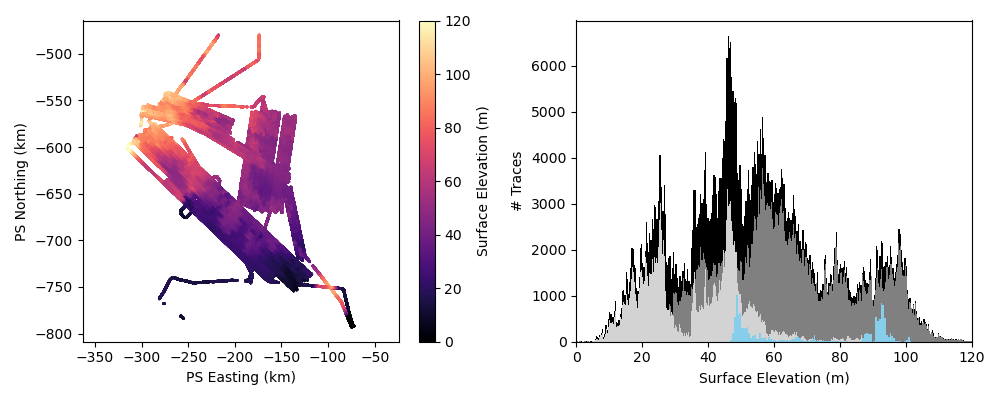

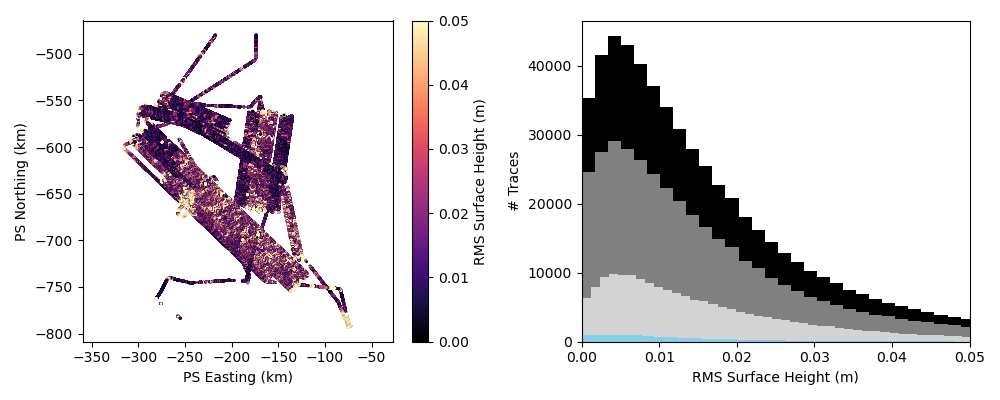

In [13]:
# Surface Elevation
plot_map_histogram(df,'S',500,100,0,120,'Surface Elevation (m)')
plt.savefig('fig-S1-9.png',dpi=300)
# Surface RMS Height
plot_map_histogram(df,'RMS_S',5000,1000,0,.05,'RMS Surface Height (m)')
plt.savefig('fig-S1-10.png',dpi=300)

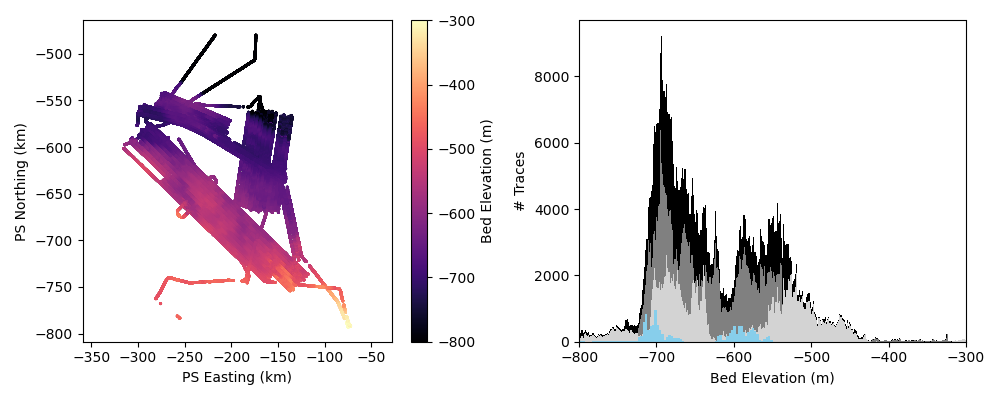

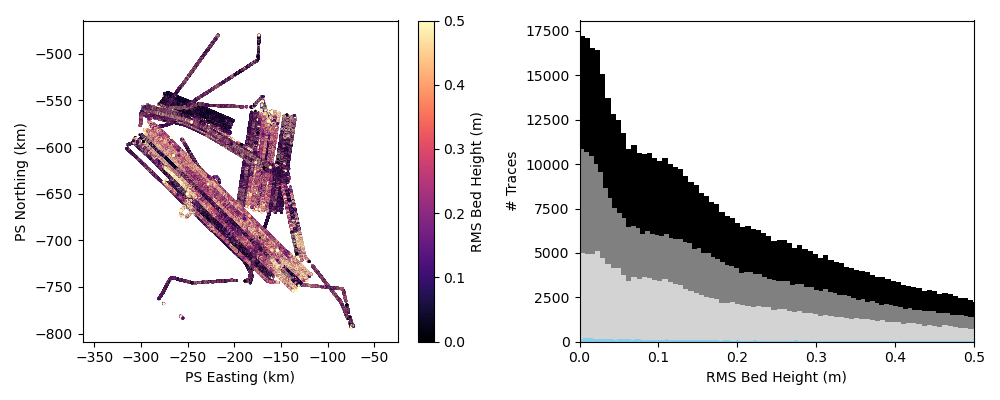

In [14]:
# Bed Elevation
plot_map_histogram(df,'B',500,100,-800,-300,'Bed Elevation (m)')
plt.savefig('fig-S1-11.png',dpi=300)
# Bed RMS Height
plot_map_histogram(df,'RMS_B',5000,1000,0,.5,'RMS Bed Height (m)')
plt.savefig('fig-S1-12.png',dpi=300)